# Github Metrics- Growth of a Repo's Community

note: https://www.zainrizvi.io/blog/jupyter-notebooks-best-practices-use-virtual-environments/ for setting up virtual environments in this RHODs JL instance.

This notebook will aim to query the Augur DB to derive measurements specified in the GitHub Community Metrics working document: https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

**Imports and Database (Augur) connection**

In [3]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import warnings
import datetime
from pandas.tseries.offsets import BusinessDay
from matplotlib.ticker import MaxNLocator
from dateutil.relativedelta import relativedelta
plt.rcParams['figure.figsize'] = (17, 5)

warnings.filterwarnings('ignore')

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], 
                                                                           config['password'], 
                                                                           config['host'], 
                                                                           config['port'], 
                                                                           config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cell - Set Variables and Filters  

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In other words, this cell translates a repo's name (augur or grimoirelab) into their respective repo-id.

In [4]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
#repo_name_set = ['augur', 'grimoirelab']
repo_name_set = ['augur']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440]


## Growth of first-time issue submitters over time

This measurement is derived from removing all non-unique and non-first entries of the same reporter_id. We are then able to track the timestamps in order of first-time issue submissions.
The resulting plot will show the aggregate number of issue-submitters vs. time.

**Query for repo's issues, ascending time**

In [5]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    i.reporter_id,
                    i.created_at
                FROM
                	issues i
                WHERE
                    i.repo_id = \'{repo_id}\'
                 ORDER BY
                    i.created_at
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
#df_issues["date_time"] = pd.to_datetime(df_issues["created_at"], format='%Y-%m-%d')
df_issues.head()

,reporter_id,created_at
0,280508,2017-01-20 14:56:01
1,280508,2017-01-20 15:04:01
2,277697,2017-01-20 20:15:51
3,280523,2017-01-23 18:00:23
4,280508,2017-01-23 18:50:08


**Drop all duplicate reporter_id's except for their first occurrence; re-sort in ascending order.**

In [6]:
# get only the first incidence of an issue-creator posting.
df_issues = df_issues.drop_duplicates(subset="reporter_id", keep="first")

# sort the values by the time/date of post.
df_issues = df_issues.sort_values("created_at")

# reset the index and drop the index - gets rid of sorting index issue.
df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)

# reset the index so index is a column, increasing (1,df.size+1)
df_issues = df_issues.reset_index()

### First-time issue creators over time

<AxesSubplot:title={'center':'# of New Augur Issue Creators vs. Time'}, xlabel='created_at'>

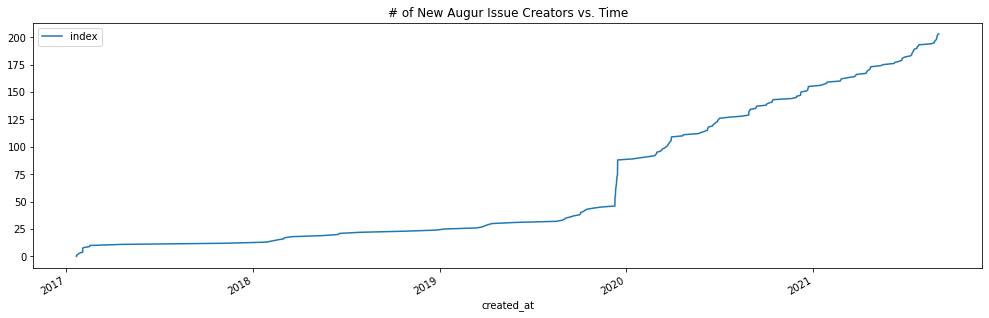

In [7]:
# plot the index of creation vs. the creation date.
df_issues.plot(x="created_at", y="index", title="# of New Augur Issue Creators vs. Time")
plt.show()

**First-time issue creators by day**

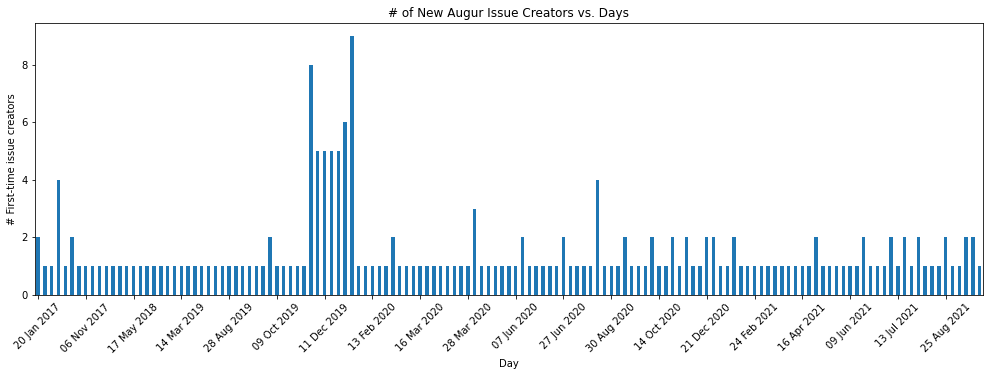

In [6]:
df_issues_daily = df_issues["created_at"].groupby(df_issues.created_at.dt.to_period("D")).agg('count')
df_issues_daily.plot.bar()

plt.xlabel("Day")
locs, labels = plt.xticks()
N = 7
plt.xticks(locs[::N], df_issues_daily.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# First-time issue creators")
plt.title("# of New Augur Issue Creators vs. Days")
plt.show()

**First-time issue creators by week**

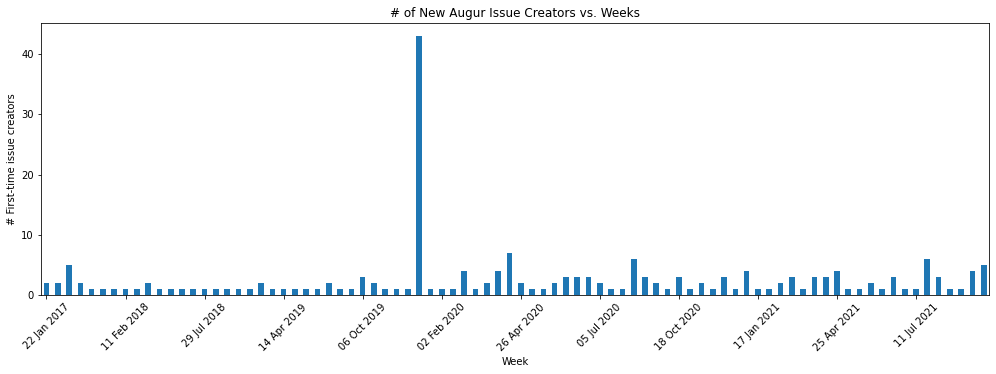

In [7]:
df_issues_weekly = df_issues["created_at"].groupby(df_issues.created_at.dt.to_period("W")).agg('count')
df_issues_weekly.plot.bar()

plt.xlabel("Week")
locs, labels = plt.xticks()
N = 7
plt.xticks(locs[::N], df_issues_weekly.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# First-time issue creators")
plt.title("# of New Augur Issue Creators vs. Weeks")
plt.show()

**First-time issue creators by month**

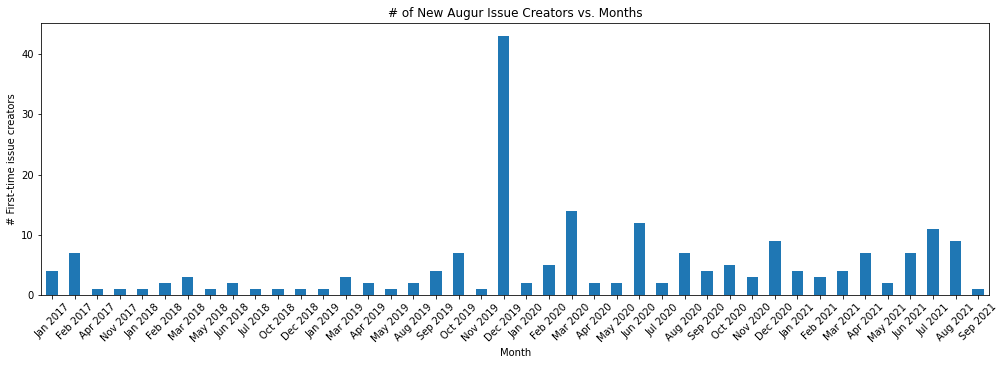

In [8]:
df_issues_monthly = df_issues["created_at"].groupby(df_issues.created_at.dt.to_period("M")).agg('count')
df_issues_monthly.plot.bar()

plt.xlabel("Month")
locs, labels = plt.xticks()
N = 1
plt.xticks(locs[::N], df_issues_monthly.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# First-time issue creators")
plt.title("# of New Augur Issue Creators vs. Months")
plt.show()

## Growth of first-time PR submitters over time

We use the same ideas from issue-submitters to find the rate of novel PR'ing for the repo.

**Query for user who made PR and timestamp of PR.**

In [9]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    p.pr_augur_contributor_id as pr_src_id,
                    p.pr_created_at
                FROM
                	pull_requests p
                WHERE
                    p.repo_id = \'{repo_id}\'
                 ORDER BY
                    p.pr_created_at
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
df_pr.head()

,pr_src_id,pr_created_at
0,277141,2017-01-23 18:50:08
1,277141,2017-01-31 17:08:16
2,277713,2017-02-01 20:33:36
3,277821,2017-02-01 20:39:53
4,277714,2017-02-01 20:41:17


**Drop all duplicate pr_src_id's except for their first occurrence; re-sort in ascending order.**

In [10]:
# get only the first incidence of a user making a pr.
df_pr = df_pr.drop_duplicates(subset="pr_src_id", keep="first")

# sort the values by the time/date of pr.
df_pr = df_pr.sort_values("pr_created_at")

# reset the index and drop the index - gets rid of sorting index problem.
df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)

# reset the index so index is a column, increasing (1,df.size+1)
df_pr = df_pr.reset_index()

### Growth of aggregate first-time PR submitters

<AxesSubplot:title={'center':'# Novel Augur PR Submitters vs. Time'}, xlabel='pr_created_at'>

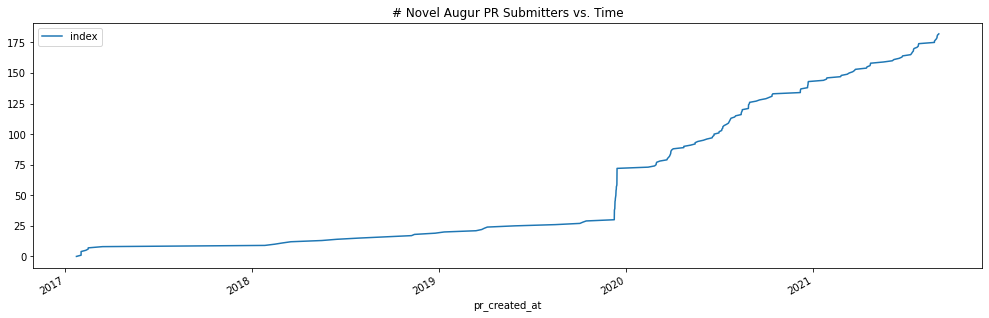

In [29]:
# plot the index of creation vs. the creation date of PR.
df_pr.plot(x="pr_created_at", y="index", title="# Novel Augur PR Submitters vs. Time")

**First-time PR submitters by day**

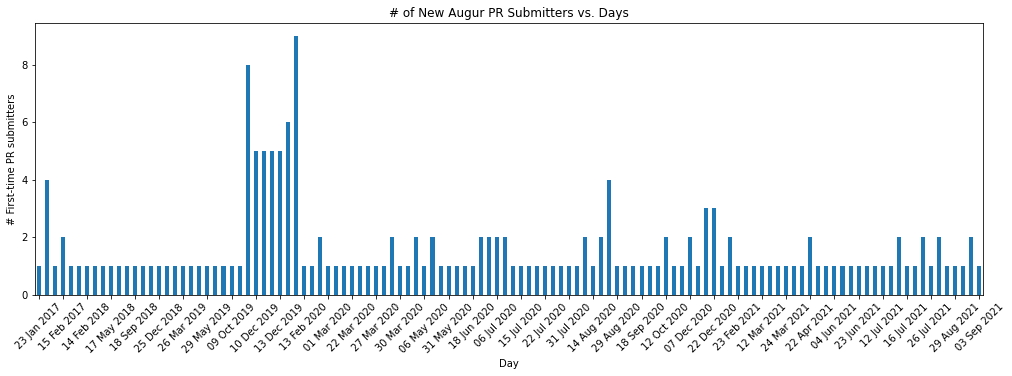

In [30]:
df_pr_daily = df_pr["pr_created_at"].groupby(df_pr.pr_created_at.dt.to_period("D")).agg('count')
df_pr_daily.plot.bar()

plt.xlabel("Day")
locs, labels = plt.xticks()
N = 3
plt.xticks(locs[::N], df_pr_daily.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# First-time PR submitters")
plt.title("# of New Augur PR Submitters vs. Days")
plt.show()

**First-time PR submitters by week**

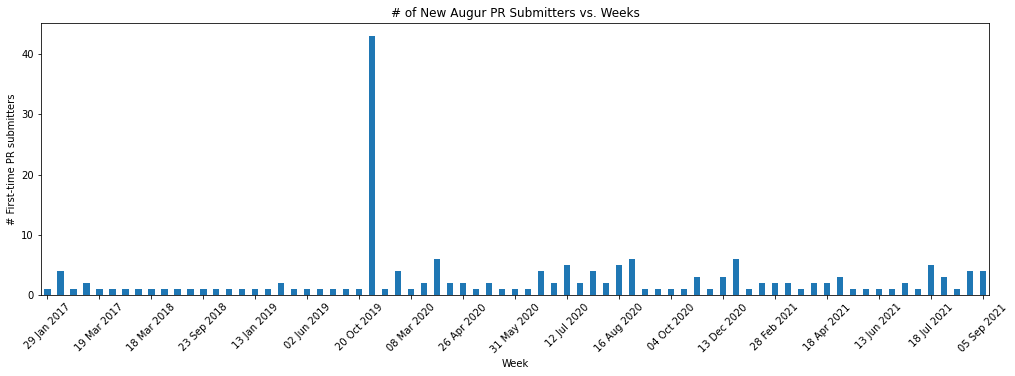

In [31]:
df_pr_weekly = df_pr["pr_created_at"].groupby(df_pr.pr_created_at.dt.to_period("W")).agg('count')
df_pr_weekly.plot.bar()

plt.xlabel("Week")
locs, labels = plt.xticks()
N = 4
plt.xticks(locs[::N], df_pr_weekly.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# First-time PR submitters")
plt.title("# of New Augur PR Submitters vs. Weeks")
plt.show()

**First-time PR submitters by month**

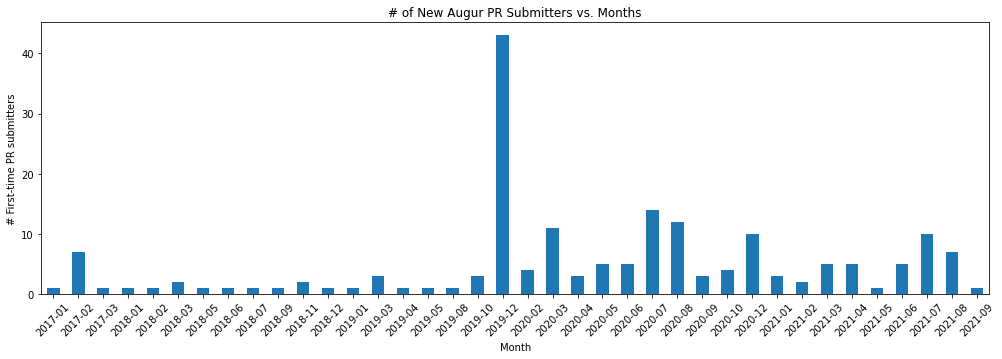

In [32]:
df_pr_monthly = df_pr["pr_created_at"].groupby(df_pr.pr_created_at.dt.to_period("M")).agg('count')
df_pr_monthly.plot.bar()

plt.xlabel("Month")
plt.xticks(rotation=45)
plt.ylabel("# First-time PR submitters")
plt.title("# of New Augur PR Submitters vs. Months")
plt.show()

## Number of Augur contributors, differentiated as "Committer" and "Author"

**Definition of a Contributor: (A) user (that) has previously committed to (the) repository.**

Ref: https://stackoverflow.com/questions/28866799/difference-between-collaborator-and-contributor

For our purposes, we'll include both those who have authored code for the project and those who have committed that authored code as 'contributors.'

We can analyze the growth of contributorship by splitting commits into novel committers and novel authors.

**Definition of an Author: An individual who writes or has written code that has become a part of the repository's code base. One does not necessarily need to have committed their authored code to be considered an author.**

**Definition of a Committer: An individiual who has one or more commits as part(s) of the commit-history of the repository's code base. One does not necessarily need to have authored the code that they included in their commits to be considered a committer.**

**For any further difficulty understanding this division, please refer to the following: https://stackoverflow.com/questions/18750808/difference-between-author-and-committer-in-git**

Through this split, we can visualize the growth of contributors who are writing new code for the project (authors). This population will likely be a near-complete match with the population of individuals who have committed changes to the project (committers), via some workflow similar to the one described above.

An explanation of the divergence between the two populations requires more inquiry.

**Query for first-time committers and first-time authors, each sorted in ascending order**

In [15]:
df_pr_committers = pd.DataFrame()
df_pr_authors = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    c.cmt_committer_name,
                    c.cmt_committer_timestamp as timestamp
                FROM
                	commits c
                WHERE
                    c.repo_id = \'{repo_id}\'
                 ORDER BY
                    c.cmt_committer_timestamp
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_committers = pd.concat([df_pr_committers, df_current_repo])
    
for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    c.cmt_author_name,
                    c.cmt_author_timestamp as timestamp
                FROM
                	commits c
                WHERE
                    c.repo_id = \'{repo_id}\'
                 ORDER BY
                    c.cmt_author_timestamp
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_authors = pd.concat([df_pr_authors, df_current_repo])

df_pr_committers = df_pr_committers.reset_index()
df_pr_committers.drop("index", axis=1, inplace=True)

df_pr_authors = df_pr_authors.reset_index()
df_pr_authors.drop("index", axis=1, inplace=True)

**Drop all duplicate cmt_committer_name's except for their first occurrence; re-sort in ascending order**

In [16]:
# Sort the committers by the commit timestamp and then keep only the first occurrence of a name.

# Get first submitted commit for a name.
df_pr_committers_unique = df_pr_committers.drop_duplicates(subset="cmt_committer_name", keep="first")

# Sort by the time of their first commit.
df_pr_committers_sorted_unique = df_pr_committers_unique.sort_values("timestamp")

# Finagle the index as a column to count number of committers.
df_pr_committers_sorted_unique = df_pr_committers_sorted_unique.reset_index()
df_pr_committers_sorted_unique.drop("index", axis=1, inplace=True)
df_pr_committers_sorted_unique = df_pr_committers_sorted_unique.reset_index()
df_pr_committers_sorted_unique

,index,cmt_committer_name,timestamp
0,0,Derek Howard,2017-01-05 18:34:55+01:00
1,1,GitHub,2017-01-11 00:16:37+01:00
2,2,Matt Germonprez,2017-01-31 17:44:19+01:00
3,3,Jake Harding,2017-02-01 21:31:19+01:00
4,4,Micah,2017-02-01 21:35:07+01:00
...,...,...,...
76,76,Brenda Kamangara,2021-07-15 19:53:18+02:00
77,77,Josh Berkus,2021-07-17 01:02:31+02:00
78,78,devika34,2021-07-25 15:02:47+02:00
79,79,arunima811,2021-07-26 20:56:22+02:00


### First-time commiters over time

<AxesSubplot:title={'center':'# Novel Augur Committers vs. Time'}, xlabel='timestamp'>

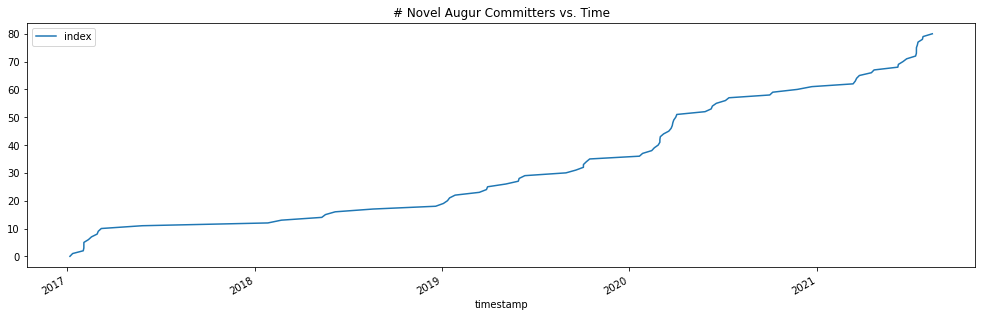

In [44]:
# plot number of unique committers over time.
df_pr_committers_sorted_unique.plot(x="timestamp", y="index", title="# Novel Augur Committers vs. Time")

In [39]:
df_pr_committers_sorted_unique['date_time'] = pd.to_datetime(df_pr_committers_sorted_unique['timestamp'], format= '%Y-%m-%d', utc=True)
df_pr_committers_sorted_unique.dtypes

index                               int64
cmt_committer_name                 object
timestamp                          object
date_time             datetime64[ns, UTC]
dtype: object

**First-time commit makers by day**

Note: Graph only shows those days on which a commit was made.

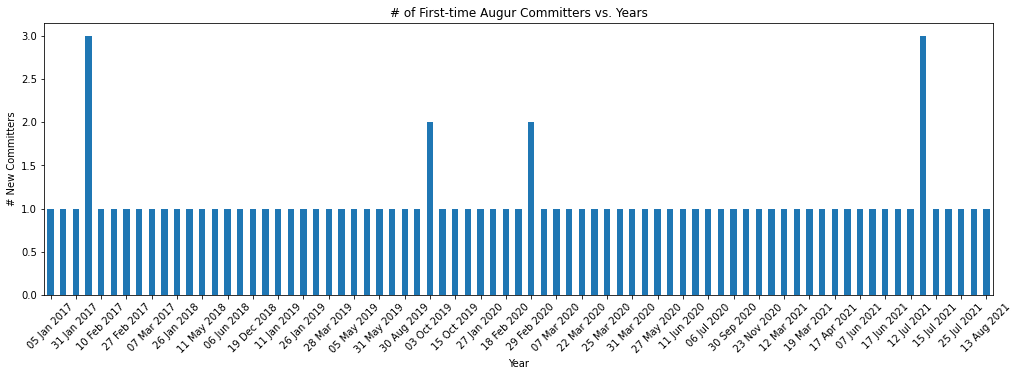

In [45]:
df_pr_committers_sorted_unique_daily = df_pr_committers_sorted_unique["date_time"].groupby(df_pr_committers_sorted_unique.date_time.dt.to_period("D")).agg('count')
df_pr_committers_sorted_unique_daily.plot.bar()

plt.xlabel("Year")
locs, labels = plt.xticks()
N = 2
plt.xticks(locs[::N], df_pr_committers_sorted_unique_daily.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# New Committers")
plt.title("# of First-time Augur Committers vs. Years")
plt.show()

**First-time commit makers by week**

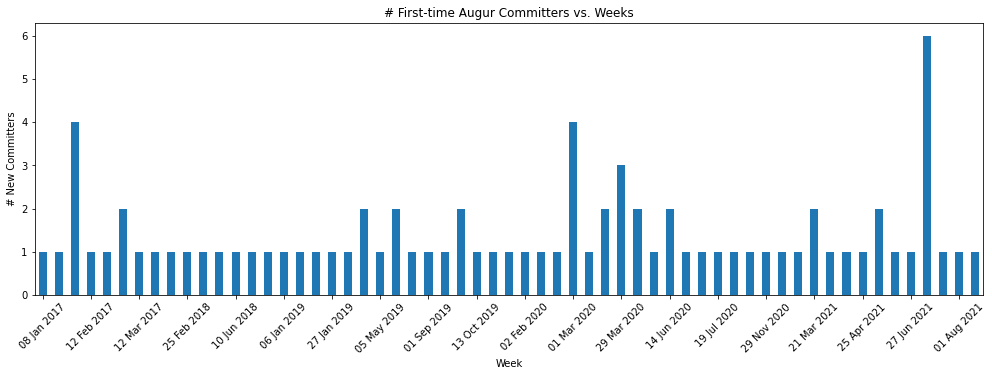

In [46]:
df_pr_committers_sorted_unique_weekly = df_pr_committers_sorted_unique["date_time"].groupby(df_pr_committers_sorted_unique.date_time.dt.to_period("W")).agg('count')
df_pr_committers_sorted_unique_weekly.plot.bar()

plt.xlabel("Week")
locs, labels = plt.xticks()
N = 3
plt.xticks(locs[::N], df_pr_committers_sorted_unique_weekly.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# New Committers")
plt.title("# First-time Augur Committers vs. Weeks")
plt.show()

**First-time commit makers by month**

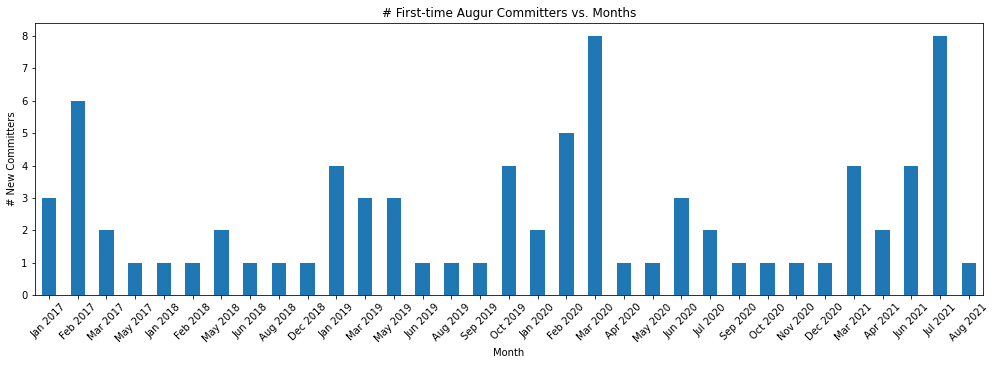

In [47]:
df_pr_committers_sorted_unique_monthly = df_pr_committers_sorted_unique["date_time"].groupby(df_pr_committers_sorted_unique.date_time.dt.to_period("M")).agg('count')
df_pr_committers_sorted_unique_monthly.plot.bar()

plt.xlabel("Month")
locs, labels = plt.xticks()
N=1
plt.xticks(locs[::N], df_pr_committers_sorted_unique_monthly.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# New Committers")
plt.title("# First-time Augur Committers vs. Months")
plt.show()

**Drop all duplicate cmt_author_name's except for their first occurrence; re-sort in ascending order.**

In [22]:
# Sort the authors by the author timestamp and then keep only the first occurrence of a name.

# Get first submitted authorship for a name.
df_pr_authors_unique = df_pr_authors.drop_duplicates(subset="cmt_author_name", keep="first")

# Sort by the time of their first authorship.
df_pr_authors_sorted_unique = df_pr_authors_unique.sort_values("timestamp")

# Finagle the index as a column to count number of authors.
df_pr_authors_sorted_unique = df_pr_authors_sorted_unique.reset_index()
df_pr_authors_sorted_unique.drop("index", axis=1, inplace=True)
df_pr_authors_sorted_unique = df_pr_authors_sorted_unique.reset_index()

### First-time commit authors over time

<AxesSubplot:title={'center':'# Novel Augur Authors vs. Time'}, xlabel='timestamp'>

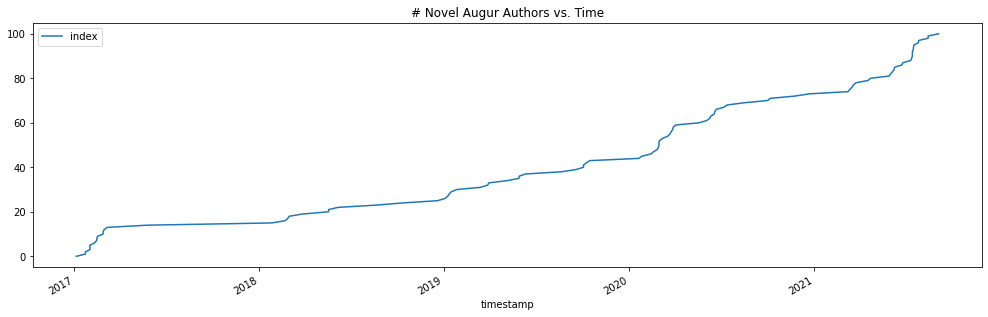

In [48]:
# plot number of unique authors over time.
df_pr_authors_sorted_unique.plot(x="timestamp", y="index", title="# Novel Augur Authors vs. Time")

**First-time Commit Authors by day**

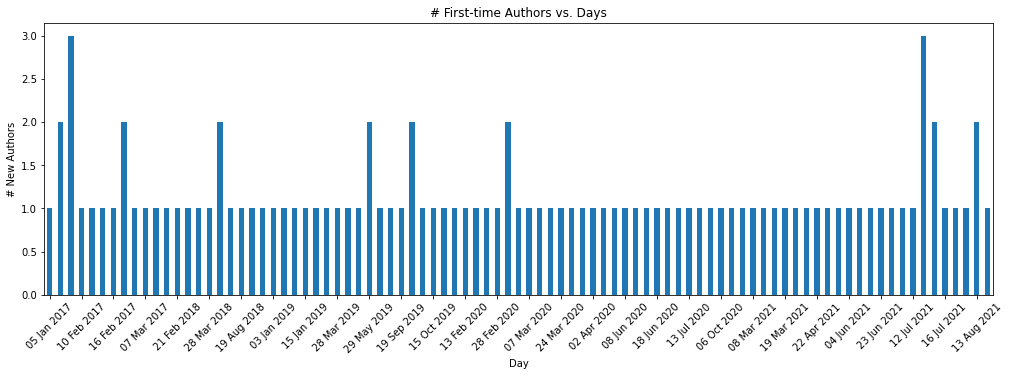

In [49]:
df_pr_authors_sorted_unique['date_time'] = pd.to_datetime(df_pr_authors_sorted_unique['timestamp'], format= '%Y-%m-%d', utc=True)

df_pr_authors_sorted_unique_daily = df_pr_authors_sorted_unique["date_time"].groupby(df_pr_authors_sorted_unique.date_time.dt.to_period("D")).agg('count')
df_pr_authors_sorted_unique_daily.plot.bar()

plt.xlabel("Day")
locs, labels = plt.xticks()
N = 3
plt.xticks(locs[::N], df_pr_authors_sorted_unique_daily.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# New Authors")
plt.title("# First-time Authors vs. Days")
plt.show()

**First-time Commit Authors makers by week**

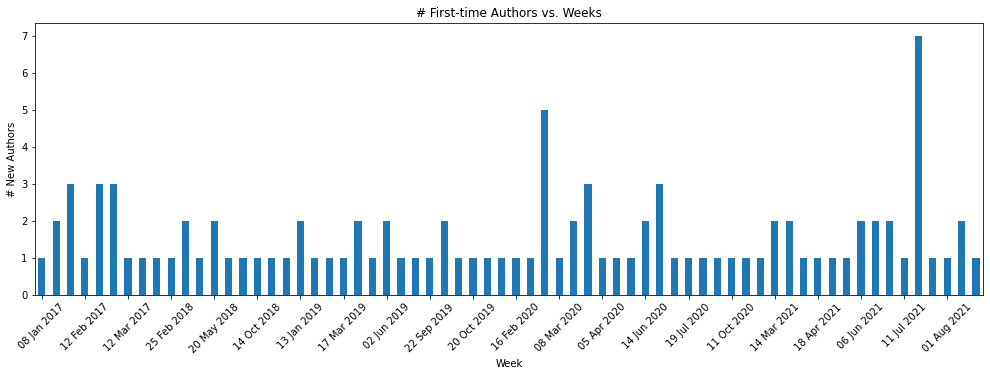

In [50]:
df_pr_authors_sorted_unique_weekly = df_pr_authors_sorted_unique["date_time"].groupby(df_pr_authors_sorted_unique.date_time.dt.to_period("W")).agg('count')
df_pr_authors_sorted_unique_weekly.plot.bar()

plt.xlabel("Week")
locs, labels = plt.xticks()
N = 3
plt.xticks(locs[::N], df_pr_authors_sorted_unique_weekly.index[::N].strftime('%d %b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# New Authors")
plt.title("# First-time Authors vs. Weeks")
plt.show()

**First-time PR Commit Authors by month**

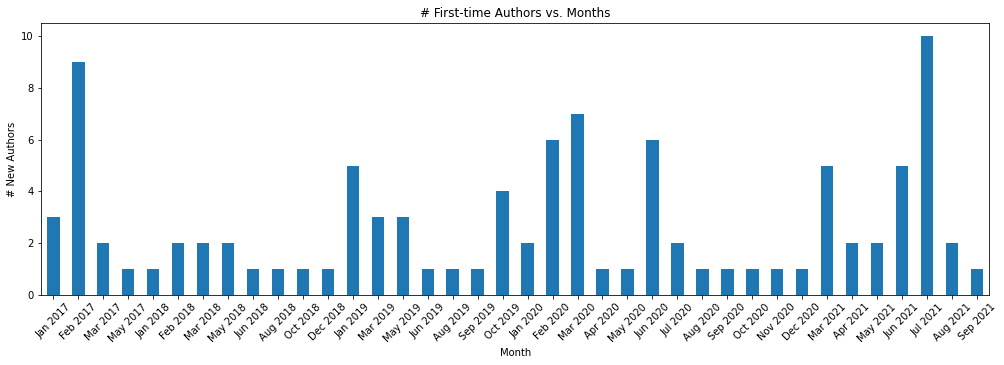

In [51]:
df_pr_authors_sorted_unique_monthly = df_pr_authors_sorted_unique["date_time"].groupby(df_pr_authors_sorted_unique.date_time.dt.to_period("M")).agg('count')
df_pr_authors_sorted_unique_monthly.plot.bar()

plt.xlabel("Month")
locs, labels = plt.xticks()
N = 1
plt.xticks(locs[::N], df_pr_authors_sorted_unique_monthly.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.ylabel("# New Authors")
plt.title("# First-time Authors vs. Months")
plt.show()

### Comparison of growth between new commit authors and new commit makers.

We see that the two growth-rates have similar shapes but non-identical growth rates. There are more novel authors than there are novel committers, indicating that in this project, some committers create commits on behalf of one or more authors.

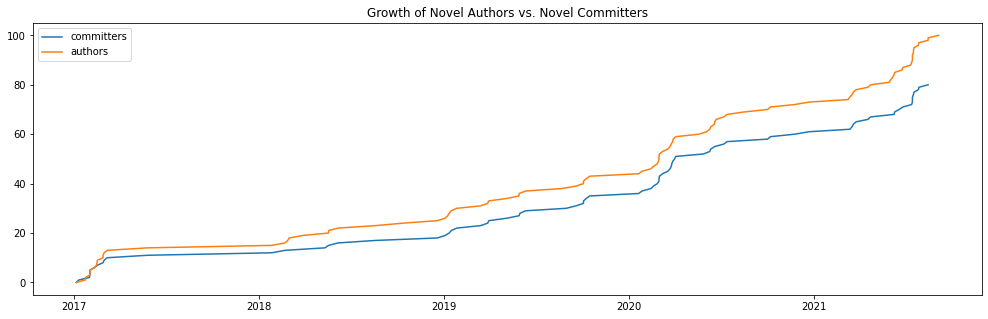

In [27]:
plt.plot(df_pr_committers_sorted_unique["timestamp"], df_pr_committers_sorted_unique["index"], label = "committers")
plt.plot(df_pr_authors_sorted_unique["timestamp"], df_pr_authors_sorted_unique["index"], label = "authors")
plt.title("Growth of Novel Authors vs. Novel Committers")
plt.legend()
plt.show()

## Organizational diversity [WIP]

There are some likely sources of this information including 'cntrb_canonical' and 'cntrb_company.' There also exists a table called 'contributor_affiliations' that we can cross-reference. Augur tracks the aliases of contributors and unifies them under a unique 'cntrb_id' which keys to all emails linked to the same account.

This presents one layer of effective analysis- we can pin activity to a single user across emails. However, it would also be nice if we could identify an individual across different accounts and different emails. For example, it would be convenient if we could see which projects an individual is working on during their corporate work, versus their personal contributions.

One suggested solution is to use fuzzy-matching between names / emails. It's likely that an individual will have overlapping emails between two accounts and potentialls overlapping names / themes for their personal / professional VC accounts.

This is an interesting problem, and one that will likely not be solved quickly.

In [28]:
df_o_divers = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    c.cntrb_login as login,
                    c.cntrb_company as company_or_institution,
                    c.cntrb_location as location,
                    c.cntrb_canonical as email
                FROM
                	contributors c
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_o_divers = pd.concat([df_o_divers, df_current_repo])

df_o_divers = df_o_divers.reset_index()
df_o_divers.drop("index", axis=1, inplace=True)
pd.set_option('display.max_columns', None)
df_o_divers

,login,company_or_institution,location,email
0,not-provided,None,None,fosterd@vmware.com
1,not-provided,None,None,fosterd@vmware.com
2,frots,None,None,fosterd@vmware.com
3,stdweird,Ghent University,"Ghent, Belgium",fosterd@vmware.com
4,acs,ThingsO2,"Getafe, Madrid, Spain",alvarodelcastillo@gmail.com
...,...,...,...,...
3495,jumping,None,"Shanghai, China",None
3496,foundatron,None,"Seattle, WA",None
3497,krionbsd,None,Europe,krion@freebsd.org
3498,wilcovian,None,None,None


## Number of Users [WIP]

We must decide how to define a 'user' in this context. 

The set of accounts that have (1) submitted an issue, (2) authored a change in a commit, (3) made a commit, (4) made a PR, (5) forked the repo, (6) merged a PR as an admit, etc. is almost certainly an imperfect subset of the users of the software itself (i.e. contributors don't necessarily use the software, users aren't necessaryily contributors). Additionally, it is likely that we can never arrive at a way of measuring the exact number of users a piece of open source software has. 

We might agree that we can get an imprecise lower-bound on the number of users by summing ( contributors + maintainers + owners + issue makers), which could be useful.

More conversation on this topic is needed in the future.